# Data Preparation:


### Importing Modules:

In [ ]:
pip install tensorflow_addons

In [ ]:
import tensorflow as tf
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

### Converting into Dataset Object



In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = tf.data.Dataset.from_tensor_slices(x_train)
y_train = tf.data.Dataset.from_tensor_slices(y_train)

x_test = tf.data.Dataset.from_tensor_slices(x_test)
y_test = tf.data.Dataset.from_tensor_slices(y_test)

training_data = tf.data.Dataset.zip((x_train,y_train))
test_data = tf.data.Dataset.zip((x_test,y_test))

### Constructing the Gaussian Kernal

In [ ]:
def gaussian_kernal(sigma=1, a=1):
  array = np.zeros((3,3))
  for i in range(-a,a+1):
    for j in range(-a,a+1):
      array[i+a, j+a] = (math.exp(-((i**2 + j**2) / (2*sigma**2)))) / (2*math.pi*sigma**2)         
  return array

gauss_expanded = gaussian_kernal()[..., np.newaxis, np.newaxis]

### Reshaping and Normalizing the Data



In [ ]:
training_data = training_data.map(lambda x, y: (tf.reshape(tf.cast(x, tf.float32), [28, 28, 1]) / 255.0, y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_data = test_data.map(lambda x, y: (tf.reshape(tf.cast(x, tf.float32), [28, 28, 1]) / 255.0, y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

##Transforming Images

In [ ]:
training_data = training_data.repeat(3)
training_data = training_data.map(lambda x, y: (tfa.image.translate(x,[tf.random.uniform([32],minval=-3,maxval=4,dtype=tf.int32),tf.random.uniform([32],minval=-3,maxval=4,dtype=tf.int32)]),y),num_parallel_calls=tf.data.experimental.AUTOTUNE)
training_data = training_data.map(lambda x, y: (tfa.image.rotate(x, tf.constant(random.randint(-5,5) * .5 * (1/math.pi))),y),num_parallel_calls=tf.data.experimental.AUTOTUNE)



### Shuffling and Batching the Data

In [ ]:
training_data = training_data.shuffle(buffer_size=1024)
training_data = training_data.batch(32)

In [ ]:
test_data = test_data.shuffle(buffer_size=1024)
test_data = test_data.batch(10000)

### Convoluting with Gaussian Kernal

In [ ]:
training_data_gauss_ker = training_data.map(lambda x, y: (tf.nn.conv2d(x, filter=gauss_expanded, padding="SAME"), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_data_gauss_ker = test_data.map(lambda x, y: (tf.nn.conv2d(x, filter=gauss_expanded, padding="SAME"), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

### General Function

In [ ]:
def generate_data(x,y, train=True, balanced=True,gaussian_kernal=False):

  d = get_batched_data(x,y,balanced)
  d= d.map(lambda x, y: (tf.reshape(tf.cast(x, tf.float32), [28, 28, 1]) / 255.0, y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

  if train:
    d = d.shuffle(buffer_size=1024)
    d = d.batch(32)
  else:
    d = d.shuffle(buffer_size=1024)
    d = d.batch(10000)

  if gaussian_kernal:
    d = d.map(lambda x, y: (tf.nn.conv2d(x, filter=gauss_expanded, padding="SAME"), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

  return d

def get_batched_data(x,y,balanced=True):
  data_len = len(y)
  x = tf.data.Dataset.from_tensor_slices(x)
  y = tf.data.Dataset.from_tensor_slices(y)
  if not balanced:
    r = tf.data.Dataset.from_tensor_slices(np.random.uniform(size = data_len))
    ds = tf.data.Dataset.zip((x, y, r))
    ds = ds.filter(lambda x, y, r: True if ((y>5 and r<.01) or y<=5) else False)
    ds = ds.map(lambda x,y,r: (x,y))
  else:
    ds = tf.data.Dataset.zip((x,y))
  return ds

### Visualizing Data

In [ ]:
x = tf.compat.v1.data.make_one_shot_iterator(training_data)

In [ ]:
np.shape(x.get_next()[1])

TensorShape([32])

In [ ]:
np.shape(img_x)

(1, 32, 28, 28, 1)

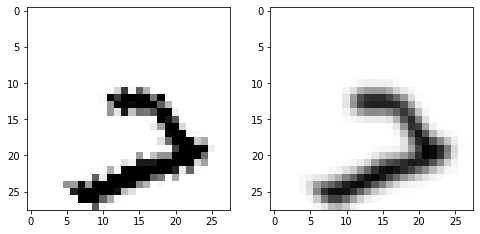

In [ ]:
img_x = x.get_next()[0][0].numpy()
img_x = np.expand_dims(img_x,0)
img_x_conv = tf.nn.conv2d(img_x, filters=gauss_expanded, strides=1,padding="SAME")
img_x_conv = np.squeeze(img_x_conv)
img_x = np.squeeze(img_x)

cmap=plt.cm.Greys
image_plot = plt.figure(figsize=(8,8))
image_plot.add_subplot(1,2,1)
plt.imshow(img_x, cmap=cmap)
image_plot.add_subplot(1,2,2)
plt.imshow(img_x_conv, cmap=cmap)
plt.show()


# Functions:

## Model Functions

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Conv2D, Dropout
from tensorflow.keras.layers import Flatten, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy

input_shape = (28, 28, 1)

class_weight_0 = [1,1,1,1,1,1,1000,1000,1000,1000]
class_weight_1 = [1,1,1,1,1,1,100,100,100,100]
class_weight_2 = [1,1,1,1,1,1,10,10,10,10]

class_weight_list = [class_weight_0,class_weight_1,class_weight_2]

def dice_loss(y_true, y_pred):
  w = tf.reduce_sum(y_true, axis = 0)
  w = 1/tf.cast(w, tf.float32)
  loss_num = tf.reduce_sum(w*(y_true * y_pred), axis = 1)
  loss_den = tf.reduce_sum(w*(y_true + y_pred), axis = 1)
  loss = tf.reduce_mean(2*(loss_num/loss_den))
  return loss

def generate_model():
  model = Sequential()
  model.add(Conv2D(54, strides = 2, kernel_size=(3,3), activation=tf.nn.relu,
                   input_shape=input_shape))
  #model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Flatten()) 
  model.add(Dense(128, activation=tf.nn.relu))
  model.add(Dropout(0.2))
  model.add(Dense(10,activation=tf.nn.softmax))
  return model

def generate_model_1():
  model = Sequential()
  model.add(Conv2D(54, strides = 2, kernel_size=(3,3), input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(Flatten()) 
  model.add(Dense(128, activation=tf.nn.relu))
  model.add(Dense(128, activation=tf.nn.relu))
  model.add(Dense(128, activation=tf.nn.relu))
  model.add(Dropout(0.2))
  model.add(Dense(10,activation=tf.nn.softmax))
  return model

def compile_model(model, use_dice_loss=False):
  if use_dice_loss:
    return model.compile(optimizer='adam', loss=dice_loss, 
                       metrics=['accuracy'])
  else:
    return model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", 
                       metrics=['accuracy'])

def fit_model(model,use_gauss=True,num_epochs=1,steps=10,class_weight=False,):
  if use_gauss:
    return model.fit(training_data_gauss_ker, epochs=num_epochs, 
                     steps_per_epoch=steps, class_weight=class_weight)
  else:
    return model.fit(training_data,epochs=num_epochs, steps_per_epoch=steps, 
                     class_weight=class_weight)

def fit_model_fixed(model,data,num_epochs=1,steps=10,class_weight=False):
    return model.fit(data, epochs=num_epochs, steps_per_epoch=steps,class_weight=class_weight)
 

def evaluate_model(model):
  with tf.Session() as sess:
    x = tf.data.make_one_shot_iterator(test_data)
    y = x.get_next()
    images, labels = sess.run(y)
  predictions = [model.predict(np.expand_dims(x, 0)) for x in images]
  predictions = [np.argmax(x) for x in predictions]
  return labels, predictions

def evaluate_model_fixed(model,data):
  with tf.Session() as sess:
    x = tf.data.make_one_shot_iterator(data)
    y = x.get_next()
    images, labels = sess.run(y)
  predictions = [model.predict(np.expand_dims(x, 0)) for x in images]
  predictions = [np.argmax(x) for x in predictions]
  return labels, predictions

## Plotting Function

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true,y_false, normalize=False, cmap=plt.cm.Blues,
                          title="Confusion Matrix"):
    cm = confusion_matrix(y_true,y_false)
    
    if normalize:
      title = title + " (Normalized)"
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
      title = title
    labels = [i for i in range(0,10)]

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), ha="center")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
            
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    fig.tight_layout()

    return ax

#Experiment #1 (Imbalanced Data)

## Creating/Training Model

In [ ]:
models = [generate_model() for i in range(2)]
for model in models:
  compile_model(model)

In [ ]:
#history = fit_model(models[0],True,10,class_weight=[0])
history = fit_model(models[0], True,num_epochs=10,steps=100)

Train on 100 steps
Epoch 1/10
100/100 [==============================] - 4s 41ms/step - loss: 0.4350 - acc: 0.8794
Epoch 2/10
100/100 [==============================] - 3s 34ms/step - loss: 0.2028 - acc: 0.9394
Epoch 3/10
100/100 [==============================] - 3s 34ms/step - loss: 0.2174 - acc: 0.9391
Epoch 4/10
100/100 [==============================] - 3s 34ms/step - loss: 0.1741 - acc: 0.9541
Epoch 5/10
100/100 [==============================] - 3s 33ms/step - loss: 0.1531 - acc: 0.9600
Epoch 6/10
100/100 [==============================] - 3s 34ms/step - loss: 0.1576 - acc: 0.9550
Epoch 7/10
100/100 [==============================] - 3s 33ms/step - loss: 0.1686 - acc: 0.9478
Epoch 8/10
100/100 [==============================] - 3s 34ms/step - loss: 0.1643 - acc: 0.9513
Epoch 9/10
100/100 [==============================] - 3s 35ms/step - loss: 0.1373 - acc: 0.9584
Epoch 10/10
100/100 [==============================] - 4s 37ms/step - loss: 0.1461 - acc: 0.9597


In [ ]:
print(history.history)

{'loss': [0.4350050989724696, 0.20283495675772428, 0.21744074389338494, 0.1740843776986003, 0.1530619137082249, 0.15756619420833887, 0.1685745550133288, 0.1642715081758797, 0.1372542796842754, 0.14609737866558134], 'acc': [0.879375, 0.939375, 0.9390625, 0.9540625, 0.96, 0.955, 0.9478125, 0.95125, 0.9584375, 0.9596875]}


In [ ]:
for i in range(3):
  fit_model(models[i],True,1,class_weight_list[i])


Train on [1, 1, 1, 1, 1, 1, 1000, 1000, 1000, 1000] steps


TypeError: ignored

In [ ]:
for i in range(3):
  models[i].evaluate(test_data)

1/1 [==============================] - 3s 3s/step - loss: 1.4021 - acc: 0.7826


In [ ]:
results = [evaluate_model(models[i]) for i in range(1)]

KeyboardInterrupt: ignored

## Visualizing Results

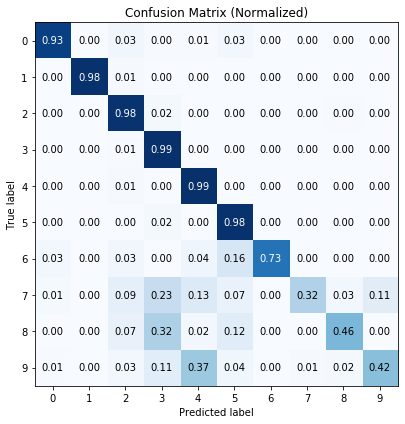

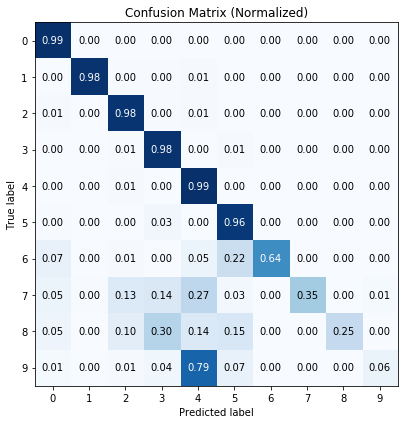

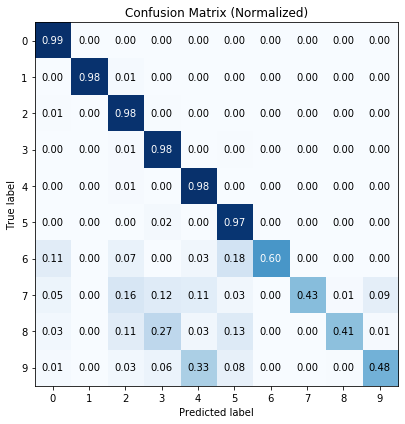

In [ ]:
np.set_printoptions(precision=2)
for i in range(3):
  plot_confusion_matrix(results[i][0],results[i][1],True)

plt.show()

# Experiment #2 (Gaussian Kernel) 

##Generating Data

In [ ]:
train_data_2_kernel = generate_data(x_train,y_train, train=True, balanced=True,gaussian_kernal=True)

train_data_2 = generate_data(x_train,y_train, train=True, balanced=True,gaussian_kernal=False)

test_data_2 = generate_data(x_test,y_test, train=False, balanced=True,gaussian_kernal=False)


## Generating/Training Model

In [ ]:
models_2_2 = [generate_model_1() for i in range(2)]
for model in models_2_2:
  compile_model(model)

In [ ]:
history_2_2=[]
history_2_2.append(fit_model_fixed(models_2_2[0],train_data_2_kernel,num_epochs=40,steps=50))
history_2_2.append(fit_model_fixed(models_2_2[1],train_data_2,num_epochs=40,steps=50))

In [ ]:
models_2 = [generate_model() for i in range(2)]
for model in models_2:
  compile_model(model)

In [ ]:
history_2=[]
history_2.append(fit_model_fixed(models_2[0],train_data_2_kernel,num_epochs=40,steps=50))
history_2.append(fit_model_fixed(models_2[1],train_data_2,num_epochs=40,steps=50))

In [ ]:
for i in range(2):
  models_2_2[i].evaluate(test_data_2)

1/1 [==============================] - 3s 3s/step - loss: 0.1466 - acc: 0.9558


In [ ]:
results_2 = [evaluate_model_fixed(models_2[i],test_data_2) for i in range(2)]

KeyboardInterrupt: ignored

## Visualizing Results

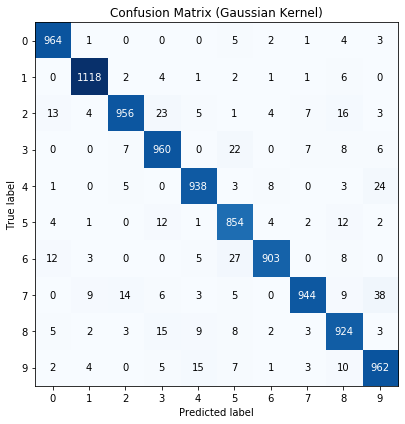

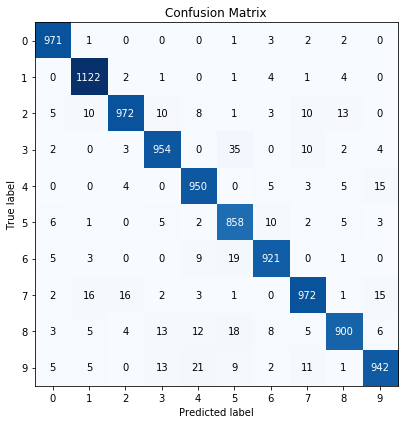

In [ ]:
np.set_printoptions(precision=2)

plot_confusion_matrix(results_2[0][0],results_2[0][1],False,title="Confusion Matrix (Gaussian Kernel)")
plot_confusion_matrix(results_2[1][0],results_2[1][1],False, title="Confusion Matrix")

plt.show()

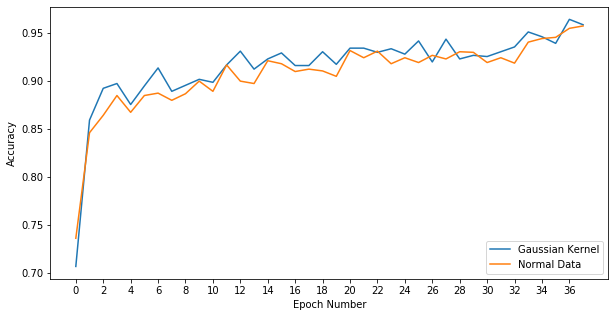

<Figure size 216x216 with 0 Axes>

In [ ]:
x = np.arange(38)
plt.figure(figsize=(10,5))


plt.plot(x,history_2[0].history["acc"])
plt.plot(x,history_2[1].history["acc"])

plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')

plt.xticks([i for i in range(0,38,2)])

plt.legend(['Gaussian Kernel', 'Normal Data'], loc='lower right')
plt.figure(figsize=(3,3))
plt.show()

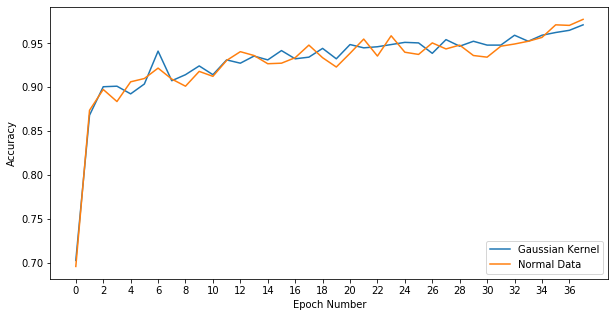

<Figure size 216x216 with 0 Axes>

In [ ]:
x = np.arange(38)
plt.figure(figsize=(10,5))


plt.plot(x,history_2_2[0].history["acc"])
plt.plot(x,history_2_2[1].history["acc"])

plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')

plt.xticks([i for i in range(0,38,2)])

plt.legend(['Gaussian Kernel', 'Normal Data'], loc='lower right')
plt.figure(figsize=(3,3))
plt.show()

# Experiment #3 (Number of Layers)

In [ ]:
train_data_3 = generate_data(x_train,y_train, train=True, balanced=True,gaussian_kernal=False)

test_data_3 = generate_data(x_test,y_test, train=False, balanced=True,gaussian_kernal=False)


In [ ]:
input_shape = (28, 28, 1)

models_3 = [0]*3

for i in range(3):
  models_3[i] = Sequential()
  models_3[i].add(Conv2D(24, kernel_size=(5,5), padding="same", activation="relu",
                   input_shape=input_shape))
  models_3[i].add(MaxPooling2D())

  if i > 0:
      models_3[i].add(Conv2D(48, kernel_size=5,padding="same", activation=tf.nn.relu,
                   input_shape=input_shape))
      models_3[i].add(MaxPooling2D())
  if i > 1:
      models_3[i].add(Conv2D(64, kernel_size=5,padding="same", activation=tf.nn.relu,
                   input_shape=input_shape))
      models_3[i].add(MaxPooling2D())

  models_3[i].add(Flatten()) 
  models_3[i].add(Dense(256, activation=tf.nn.relu))
  models_3[i].add(Dense(10,activation=tf.nn.softmax))    
  models_3[i].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [ ]:
history_3=[]
for i in range(3):
  history_3.append(models_3[i].fit(train_data_3, epochs=15, steps_per_epoch=100,
                             validation_data=test_data_3))

Train on 100 steps, validate on 1 steps
Epoch 1/15
100/100 [==============================] - 8s 78ms/step - loss: 0.6096 - acc: 0.8300 - val_loss: 0.2828 - val_acc: 0.9108
Epoch 2/15
100/100 [==============================] - 7s 73ms/step - loss: 0.2511 - acc: 0.9225 - val_loss: 0.2388 - val_acc: 0.9267
Epoch 3/15
100/100 [==============================] - 7s 74ms/step - loss: 0.1906 - acc: 0.9447 - val_loss: 0.1702 - val_acc: 0.9474
Epoch 4/15
100/100 [==============================] - 7s 73ms/step - loss: 0.1670 - acc: 0.9503 - val_loss: 0.1365 - val_acc: 0.9574
Epoch 5/15
100/100 [==============================] - 7s 72ms/step - loss: 0.1283 - acc: 0.9591 - val_loss: 0.1164 - val_acc: 0.9651
Epoch 6/15
100/100 [==============================] - 7s 73ms/step - loss: 0.1061 - acc: 0.9675 - val_loss: 0.0886 - val_acc: 0.9725
Epoch 7/15
100/100 [==============================] - 7s 73ms/step - loss: 0.0955 - acc: 0.9719 - val_loss: 0.0944 - val_acc: 0.9685
Epoch 8/15
100/100 [=========

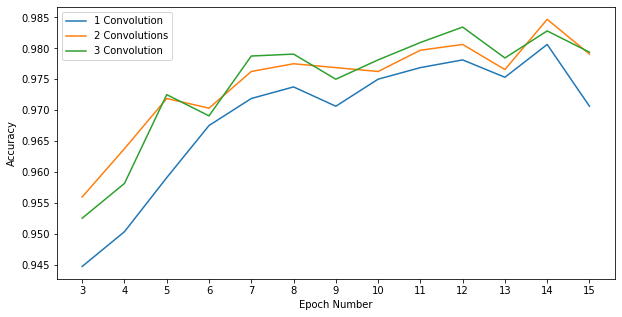

<Figure size 216x216 with 0 Axes>

In [ ]:
x = np.arange(13)
plt.figure(figsize=(10,5))


plt.plot(x,history_3[0].history["acc"][2:])
plt.plot(x,history_3[1].history["acc"][2:])
plt.plot(x,history_3[2].history["acc"][2:])


plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')

plt.xticks([i for i in range(13)],[i for i in range(3,16)])

plt.legend(['1 Convolution', '2 Convolutions','3 Convolution'], loc='best')

plt.figure(figsize=(3,3))
plt.show()

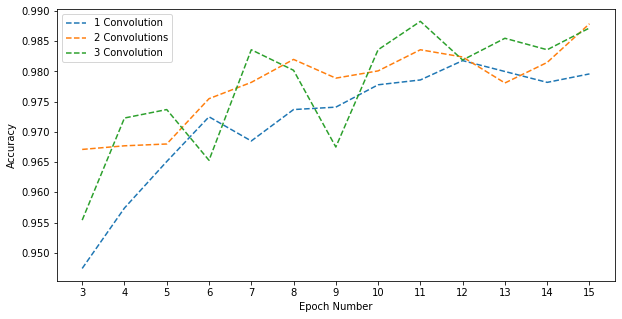

<Figure size 216x216 with 0 Axes>

In [ ]:
x = np.arange(13)
plt.figure(figsize=(10,5))


plt.plot(x,history_3[0].history['val_acc'][2:],'--')
plt.plot(x,history_3[1].history['val_acc'][2:],'--')
plt.plot(x,history_3[2].history['val_acc'][2:],'--')

plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')

plt.xticks([i for i in range(13)],[i for i in range(3,16)])

plt.legend(['1 Convolution', '2 Convolutions','3 Convolution'], loc='best')
plt.figure(figsize=(3,3))
plt.show()

In [ ]:
history_3[0].history

# Experiment #4 (MaxPooling2D)

In [ ]:
train_data_4 = generate_data(x_train,y_train, train=True, balanced=True,gaussian_kernal=False)
test_data_4 = generate_data(x_test,y_test, train=False, balanced=True,gaussian_kernal=False)

In [ ]:
from tensorflow.keras.layers import AveragePooling2D

models_4 = [0,0]
for i in range(2):
  models_4[i] = Sequential()
  models_4[i].add(Conv2D(24, kernel_size=(5,5), padding="same", activation="relu",
                   input_shape=input_shape))
  if i == 0:
    models_4[i].add(MaxPooling2D())

  if i == 1:
    models_4[i].add(AveragePooling2D())

  models_4[i].add(Flatten()) 
  models_4[i].add(Dense(256, activation=tf.nn.relu))
  models_4[i].add(Dense(10,activation=tf.nn.softmax))    
  models_4[i].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
history_4=[]
for i in range(2):
  history_4.append(fit_model_fixed(models_4[i],train_data_4,num_epochs=15,steps=100))


Train on 100 steps
Epoch 1/15
100/100 [==============================] - 4s 44ms/step - loss: 0.6035 - acc: 0.8256
Epoch 2/15
 55/100 [===============>..............] - ETA: 1s - loss: 0.2747 - acc: 0.9210

KeyboardInterrupt: ignored

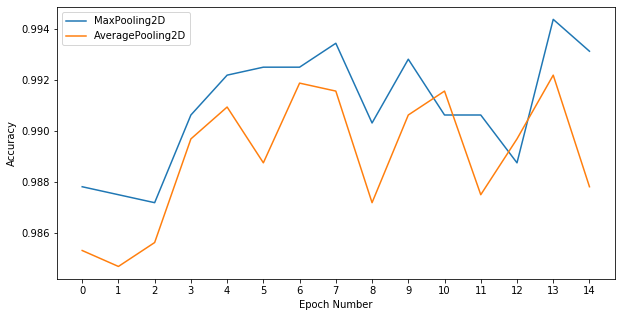

<Figure size 216x216 with 0 Axes>

In [ ]:
x = np.arange(15)

plt.figure(figsize=(10,5))

plt.plot(x,history_4[0].history["acc"])
plt.plot(x,history_4[1].history["acc"])


plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')

plt.xticks([i for i in range(15)])

plt.legend(['MaxPooling2D', 'AveragePooling2D'], loc='best')
plt.figure(figsize=(3,3))
plt.show()

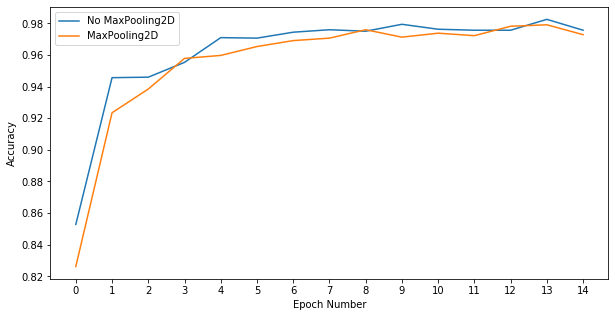

<Figure size 216x216 with 0 Axes>

In [ ]:
x = np.arange(15)

plt.figure(figsize=(10,5))

plt.plot(x,history_4[0].history["acc"])
plt.plot(x,history_4[1].history["acc"])


plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')

plt.xticks([i for i in range(15)])

plt.legend(['No MaxPooling2D', 'MaxPooling2D'], loc='best')
plt.figure(figsize=(3,3))
plt.show()

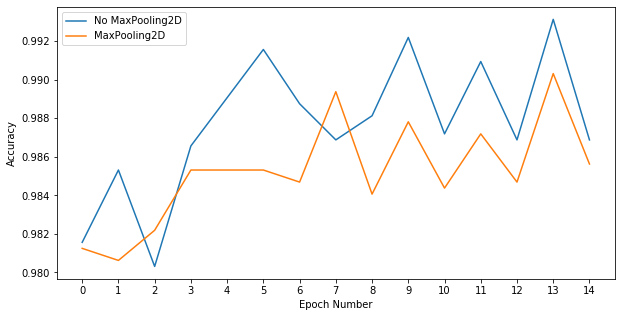

<Figure size 216x216 with 0 Axes>

In [ ]:
x = np.arange(15)

plt.figure(figsize=(10,5))

plt.plot(x,history_4[0].history["acc"])
plt.plot(x,history_4[1].history["acc"])


plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')

plt.xticks([i for i in range(15)])

plt.legend(['No MaxPooling2D', 'MaxPooling2D'], loc='best')
plt.figure(figsize=(3,3))
plt.show()

In [ ]:
for i in range(2):
  models_4[i].evaluate(test_data_4)

1/1 [==============================] - 3s 3s/step - loss: 0.0488 - acc: 0.9848


# Experiment #5 (Dropout Value)

In [ ]:
train_data_5 = training_data_extended
test_data_5 = training_data_extended

In [ ]:
input_shape = (28, 28, 1)

models_5 = [0]*9

for i in range(9):
  models_5[i] = Sequential()
  models_5[i].add(Conv2D(24, kernel_size=(5,5), padding="same", activation="relu",
                   input_shape=input_shape))
  models_5[i].add(MaxPooling2D())
  models_5[i].add(Conv2D(48, kernel_size=5,padding="same", activation=tf.nn.relu,
                   input_shape=input_shape))
  models_5[i].add(MaxPooling2D())

  models_5[i].add(Flatten()) 
  models_5[i].add(Dense(256, activation=tf.nn.relu))
  models_5[i].add(Dropout(.1*i))
  models_5[i].add(Dense(10,activation=tf.nn.softmax))    
  models_5[i].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model = [0]*9
for j in range(9):
    model[j] = Sequential()
    model[j].add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1)))
    model[j].add(MaxPooling2D())
    model[j].add(Dropout(j*0.1))
    model[j].add(Conv2D(64,kernel_size=5,activation='relu'))
    model[j].add(MaxPooling2D())
    model[j].add(Dropout(j*0.1))
    model[j].add(Flatten())
    model[j].add(Dense(128, activation='relu'))
    model[j].add(Dropout(j*0.1))
    model[j].add(Dense(10, activation='softmax'))
    model[j].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history_5=[0]*9

In [ ]:

history_5[0]=model[0].fit(training_data_extended, epochs=25, steps_per_epoch=150, verbose=1)

Train for 150 steps
Epoch 1/25
150/150 [==============================] - 7s 49ms/step - loss: 0.5626 - accuracy: 0.8302
Epoch 2/25
150/150 [==============================] - 7s 44ms/step - loss: 0.1866 - accuracy: 0.9425
Epoch 3/25
150/150 [==============================] - 7s 44ms/step - loss: 0.1173 - accuracy: 0.9615
Epoch 4/25
150/150 [==============================] - 7s 44ms/step - loss: 0.1027 - accuracy: 0.9673
Epoch 5/25
150/150 [==============================] - 6s 42ms/step - loss: 0.0658 - accuracy: 0.9802
Epoch 6/25
150/150 [==============================] - 7s 44ms/step - loss: 0.0889 - accuracy: 0.9723
Epoch 7/25
150/150 [==============================] - 7s 44ms/step - loss: 0.0675 - accuracy: 0.9773
Epoch 8/25
150/150 [==============================] - 7s 44ms/step - loss: 0.0700 - accuracy: 0.9787
Epoch 9/25
150/150 [==============================] - 7s 45ms/step - loss: 0.0677 - accuracy: 0.9779
Epoch 10/25
150/150 [==============================] - 7s 45ms/step - l

In [ ]:
history_5[0].history['accuracy']

[0.83020836,
 0.9425,
 0.9614583,
 0.96729165,
 0.98020834,
 0.97229165,
 0.97729164,
 0.97875,
 0.97791666,
 0.9791667,
 0.980625,
 0.985625,
 0.96770835,
 0.9770833,
 0.97833335,
 0.9839583,
 0.98645836,
 0.98645836,
 0.9875,
 0.9841667,
 0.9870833,
 0.988125,
 0.9841667,
 0.98520833,
 0.99291664]

In [ ]:
history_5=[]
for i in range(9):
  history_5.append(models_5[i].fit(train_data_5, epochs=30, steps_per_epoch=100,verbose=2))

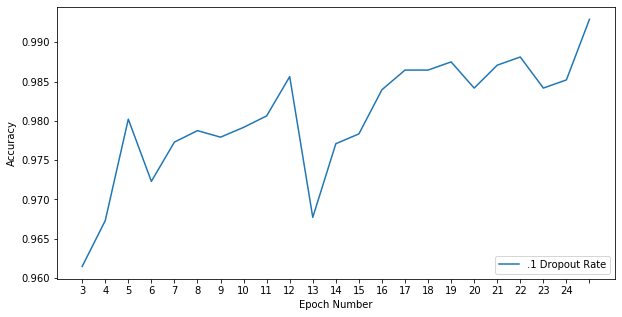

<Figure size 216x216 with 0 Axes>

In [ ]:
x = np.arange(23)
plt.figure(figsize=(10,5))


plt.plot(x,history_5[0].history["accuracy"][2:])

plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')

plt.xticks([i for i in range(23)],[i for i in range(3,25)])

plt.legend([".1 Dropout Rate"], loc='lower right')
plt.figure(figsize=(3,3))
plt.show()

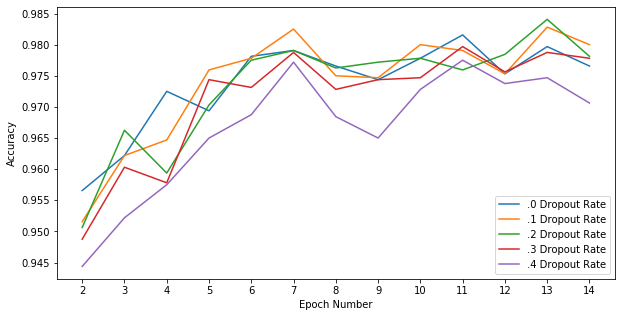

<Figure size 216x216 with 0 Axes>

In [ ]:
x = np.arange(13)
plt.figure(figsize=(10,5))


plt.plot(x,history_5[0].history["acc"][2:])
plt.plot(x,history_5[1].history["acc"][2:])
plt.plot(x,history_5[2].history["acc"][2:])
plt.plot(x,history_5[3].history["acc"][2:])
plt.plot(x,history_5[4].history["acc"][2:])


plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')

plt.xticks([i for i in range(13)],[i for i in range(2,15)])

plt.legend(['.'+str(i)+' Dropout Rate' for i in range(5)], loc='lower right')
plt.figure(figsize=(3,3))
plt.show()

In [ ]:
for i in range(5):
  models_5[i].evaluate(test_data_5)

1/1 [==============================] - 6s 6s/step - loss: 0.0468 - acc: 0.9853


# Experiment #6 (Gaussian Kernel)

In [ ]:
train_data_6_gauss = generate_data(x_train,y_train, train=True, balanced=True,gaussian_kernal=True)

train_data_6 = generate_data(x_train,y_train, train=True, balanced=True,gaussian_kernal=False)

test_data_6 = generate_data(x_test,y_test, train=False, balanced=True,gaussian_kernal=False)

In [ ]:
input_shape = (28, 28, 1)

models_6 = [0]*2

for i in range(2):
  models_6[i] = Sequential()
  models_6[i].add(Conv2D(24, kernel_size=(5,5), padding="valid", activation="relu",
                   input_shape=input_shape))
  models_6[i].add(MaxPooling2D())
  models_6[i].add(Conv2D(48, kernel_size=5,padding="valid", activation=tf.nn.relu,
                   input_shape=input_shape))
  models_6[i].add(MaxPooling2D())
  models_6[i].add(Flatten()) 
  models_6[i].add(Dense(256, activation=tf.nn.relu))
  models_6[i].add(Dropout(.3))
  models_6[i].add(Dense(10,activation=tf.nn.softmax))    
  models_6[i].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history_6=[]

history_6.append(models_6[0].fit(train_data_6_gauss, epochs=15, steps_per_epoch=100,verbose=1,validation_data=test_data_6))
history_6.append(models_6[1].fit(train_data_6, epochs=15, steps_per_epoch=100,verbose=1,validation_data=test_data_6))

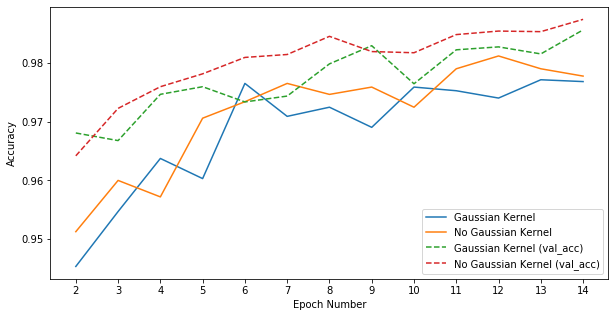

<Figure size 216x216 with 0 Axes>

In [ ]:
x = np.arange(13)
plt.figure(figsize=(10,5))


plt.plot(x,history_6[0].history["acc"][2:])
plt.plot(x,history_6[1].history["acc"][2:])
plt.plot(x,history_6[0].history["val_acc"][2:],'--')
plt.plot(x,history_6[1].history["val_acc"][2:],'--')

plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')

plt.xticks([i for i in range(13)],[i for i in range(2,15)])

plt.legend(["Gaussian Kernel", "No Gaussian Kernel","Gaussian Kernel (val_acc)", "No Gaussian Kernel (val_acc)"], loc='lower right')
plt.figure(figsize=(3,3))
plt.show()

# Final Model

In [ ]:
results_6 = [evaluate_model_fixed(models_6[i],test_data_6) for i in range(2)]

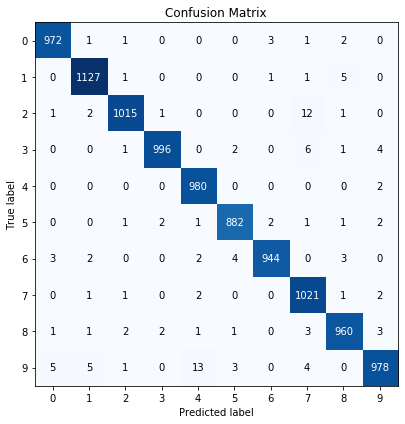

In [ ]:
plot_confusion_matrix(results_6[1][0],results_6[1][1],False, title="Confusion Matrix")


.eps format for matlab (Vectorized Image)
More formal/precise language for the doc
Test more values for Dropout rate and explain why
 Adam optimizer -> Change phrasing. ODE Net 